## Machine learning for twitter sentiment analysis
In this exercise we will be using two data sets containing tweets to predict the sentiments of the tweets. The first data set (sentiment_analysis.csv) contains generic tweets and the second data set (US_Elections_2020.csv) contains tweets pertaining to the US 2020 elections. We will first preprocess the dataset and vectorize the data sets. We will then apply 7 different machine learning algorithms to train and predict the sentiments for the generic tweets data. We will then evaluate the models using the elections data set.

The second part of the exercise involves using three machine learning models to predict the negative reasons of the tweets in the elections data set. The hyperparameters of the three ML models are tuned and the final predictions are discussed.

In [1]:
!pip install regex
!pip install nltk
!pip install wordcloud
!pip install xgboost

In [2]:
# Let us first import the necessary modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import regex as re
import html
from nltk.tokenize import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer, WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import make_scorer, confusion_matrix
import scipy
from sklearn import metrics
import timeit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [3]:
# Import the sentiment_analysis dataset
sentiment = pd.read_csv('C:\\Users\KrishnaPratheeba\Documents\MEngCEM\MIE1624 Data science and analytics\Assignment 3\sentiment_analysis.csv')
sentiment.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


In [4]:
sentiment.iloc[0]['text']

'Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0'

## Part 1: Data Cleaning
Since we are dealing with online user generated data, it will contain many undesirable characters which should be removed or converted to a different format to effectively use it in our analysis. We will clean the tweets from both the datasets to use it for further analysis.

In [5]:
# import STOPWORDS from the stopwords module to use in generic tweets dataset
stop_words = set(STOPWORDS)
stop_words.update(["b'rt",'rt',"n't"])

# import separate stopwords list to use on the US_Elections_2020 dataset
text_file = open('C:\\Users\KrishnaPratheeba\Documents\MEngCEM\MIE1624 Data science and analytics\Assignment 3\stop_words.txt')
words = text_file.read()
stop_words1 = words.splitlines()
stop_words1.extend(("b'rt",'rt',"n't"))
stop_words1[:5]

['a', 'able', 'about', 'above', 'abst']


Let us clean the 'text' column of the sentiment data set by removing html tags & attributes, URLs, stop words. Also HTML character codes will be replaced with ascii equivalents and characters are converted to lower case. The clean text is saved under 'text1' column.

In [6]:
sentiment['text1'] = sentiment['text']
tags = re.compile(r'/<[^>]+>/') #attributes to remove
tags1 = r'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]' #non-english characters to remove
sentiment['text'] = [html.unescape(sentiment.iloc[i]['text']) for i in tqdm(range(len(sentiment)))]
sentiment['text'] = [re.sub(tags,'',sentiment.iloc[i]['text']) for i in tqdm(range(len(sentiment)))]
sentiment['text'] = [re.sub(tags1,'',sentiment.iloc[i]['text']) for i in tqdm(range(len(sentiment)))]
sentiment['text'] = [re.sub(r'http\S+','',sentiment.iloc[i]['text']).lower() for i in tqdm(range(len(sentiment)))]
sentiment['text1'] = [word_tokenize(sentiment.iloc[i]['text']) for i in tqdm(range(len(sentiment)))]
sentiment['text1'] = [(" ").join(w for w in sentiment.iloc[i]['text1'] if not w in stop_words) for i in tqdm(range(len(sentiment)))]

100%|██████████| 550391/550391 [01:46<00:00, 5180.56it/s]


In [7]:
sentiment['text1'][18693]

'@ bhushanadhau1 : end part song damn amazing kat goes sid & smile awww loved nachde ne saare'

In [8]:
sentiment.head() #Check the generic tweets dataframe after cleaning

,ID,text,label,text1
0,7.680980e+17,josh jenkins is looking forward to tab breeder...,1,josh jenkins looking forward tab breeders crow...
1,7.680980e+17,rt @mianusmanjaved: congratulations pakistan o...,1,@ mianusmanjaved : congratulations pakistan be...
2,7.680980e+17,"rt @pepalerts: this september, @yesmag is taki...",1,"@ pepalerts : september , @ yesmag taking main..."
3,7.680980e+17,"rt @david_gaibis: newly painted walls, thanks ...",1,"@ david_gaibis : newly painted walls , thanks ..."
4,7.680980e+17,rt @cedricfeschotte: excited to announce: as o...,1,@ cedricfeschotte : excited announce : july 20...



The same cleaning process is applied for the elections dataset later

## Part 2: Exploratory Analysis


We will now visualize the cleaned generic data set tweets through a word cloud. A wordcloud is an image composed of words used in a particular text or subject, in which the size of each word indicates its frequency or importance.

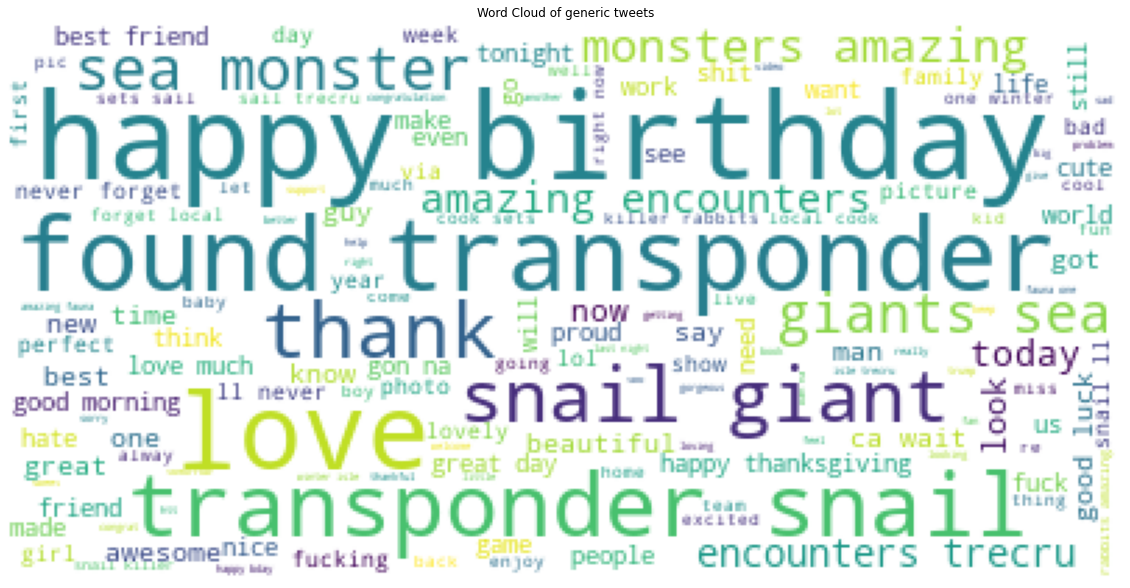

In [9]:
text_sentiment = " ".join(x for x in sentiment.text1)

word_cloud = WordCloud(stopwords = stop_words, background_color = "white").generate(text_sentiment)
plt.figure(figsize=(20,30))
plt.imshow(word_cloud)
plt.title('Word Cloud of generic tweets')
plt.axis('off')
plt.show()

From the above image we can see that words like 'happy birthday','love','transponder','found','snail','giant,'monster', etc. are the most used words in the data set. We can infer that the data set relates to a kids event or an attraction.

Let us repeat the data cleaning and visualization process for the US_Elections_2020 data set now.

In [10]:
election = pd.read_csv('US_Elections_2020.csv') # Import the data

In [11]:
election.head() # Examine the sample data

,text,sentiment,negative_reason
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19
3,b'Every 107 seconds an American is dying from ...,1,NaN
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,NaN


In [12]:
# Initiate stemming and lemmatizing functions for data cleaning
ps = PorterStemmer()
lem = WordNetLemmatizer()

In [13]:
#cleaning the 'text' column of the elections dataset, which contains the tweets. Store the cleaned text in a new column 'text1'
election['text1'] = election['text']
tags = re.compile(r'/<[^>]+>/')
election['text'] = [re.sub(tags,'',election.iloc[i]['text']) for i in tqdm(range(len(election)))]
election['text'] = [html.unescape(election.iloc[i]['text']) for i in tqdm(range(len(election)))]
election['text'] = [re.sub(r'http\S+','',election.iloc[i]['text']).lower() for i in tqdm(range(len(election)))]
election['tokens'] = [word_tokenize(election.iloc[i]['text']) for i in tqdm(range(len(election)))]
for i in election.index:
      election['tokens'][i] = [lem.lemmatize(word) for word in election.iloc[i]['tokens']]
election['text1'] = [(" ").join(w for w in election.iloc[i]['tokens'] if not w in stop_words1) for i in tqdm(range(len(election)))]

100%|██████████| 2552/2552 [00:00<00:00, 2713.44it/s]


In [14]:
election.iloc[5]['text']

'accelerating. & rising when all #americans killed by #trumpvirus are '

We will now visualize the cleaned elections data set tweets through a word cloud.

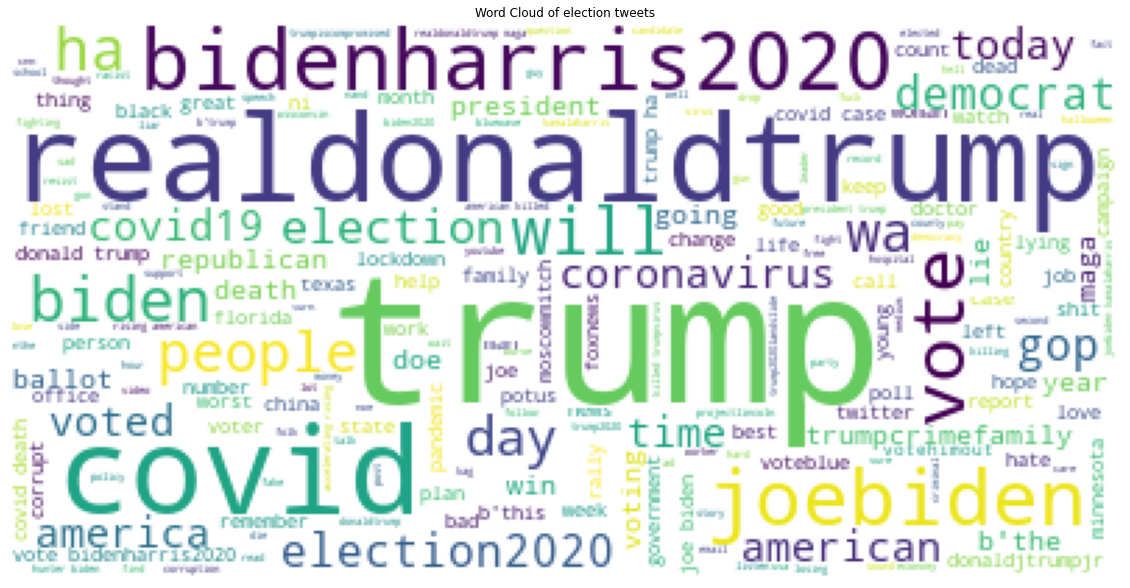

In [15]:
text = " ".join(x for x in election.text1)
word_cloud = WordCloud(stopwords = stop_words1, background_color = "white").generate(text)
plt.figure(figsize=(20,30))
plt.imshow(word_cloud)
plt.title('Word Cloud of election tweets')
plt.axis('off')
plt.show()

From the above image we can see that words like 'trump', 'joebiden', 'bidenharris2020', 'covid', 'vote', 'election', 'election2020', etc. are the most frequently used words in the data set. We can infer that the data set relates to the 2020 presidential elections in the US.

Let us now identify the political affiliation of the tweeters using the key words in their tweets. Firstly, from the wordcloud, we can identify the keywords that are synonymous with both the parties. Then we will compare the words of each tokenized tweets with the keywords list. If the keyword that is present in one of the two lists is present in the tweet and if the sentiment is positive, then the tweeter is identified as being affiliated with that political party. 

For example, if a keyword from the 'republican' list is present in the tweet and if the sentiment of the tweet is positive, then the tweeter is a republican. If not she/he is a democrat, and vice-versa.

In [16]:
republican = ['trump', 'realdonaldtrump','republican','donaldjtrumpjr','donald trump','potus','gop','republic','maga','lie','office','president','foxnews','mike','pence','melania','ivanka','right','trumpcrimefamily','votehimout','mask','covid death','black']
democrat = ['impeach','covid','corona','virus','joebiden','bidenharris2020','biden','democrat','joe biden','dnc','democrats','harris','kamala','joe','left']

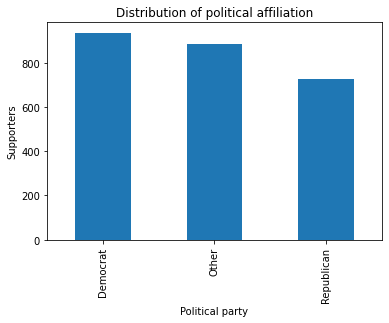

In [17]:
election['party'] = ''
for i in election.index:
    for w in election.iloc[i]['tokens']:
        if w in republican and w in  election.iloc[i]['tokens'] and election.iloc[i]['sentiment']==1:
            election['party'][i] = 'Republican'
            break
        elif w in republican and w in  election.iloc[i]['tokens'] and election.iloc[i]['sentiment']==0:
            election['party'][i] = 'Democrat'
            break
        elif w in democrat and w in election.iloc[i]['tokens'] and election.iloc[i]['sentiment']==1:
            election['party'][i] = 'Democrat'
            break
        elif w in democrat and w in election.iloc[i]['tokens'] and election.iloc[i]['sentiment']==0:
            election['party'][i] = 'Republican'
            break
        else:
            election['party'][i] = 'Other'
    if election['party'][i] =='':
        election['party'][i] = 'Other'
election['party'].value_counts().plot(kind='bar')
plt.xlabel('Political party')
plt.ylabel('Supporters')
plt.title('Distribution of political affiliation')
plt.show()

From the above distribution we can see that there are more supporters to the democratic party than the republican party. A large number of the tweeters are neither democrats/republicans. This means that they did not express any political support to both the parties or they supported some party other than the two parties.

In [18]:
election.iloc[19]['text']

"b'rt @iwashington: vote like your lives depends on it, because it does. #maga "

In [19]:
election.head() #the political affiliation column ('party') is added at the end of the dataframe

,text,sentiment,negative_reason,text1,tokens,party
0,"b'@robreiner so afraid of nov, dec, and jan! e...",0,covid19,"' @ robreiner afraid nov , dec , jan ! # biden...","[b, ', @, robreiner, so, afraid, of, nov, ,, d...",Republican
1,"b""rt @suec00k: lord sumption launches recovery...",0,others,'' @ suec00k : lord sumption launch recovery -...,"[b, '', rt, @, suec00k, :, lord, sumption, lau...",Republican
2,b'rt @walidphares: uber timing: after #biden a...,0,covid19,@ walidphares : uber timing : # biden advisor ...,"[b'rt, @, walidphares, :, uber, timing, :, aft...",Republican
3,b'every 107 seconds an american is dying from ...,1,NaN,b'every 107 second american dying # trumpvirus...,"[b'every, 107, second, an, american, is, dying...",Democrat
4,b'rt @thewebbix: the #democrats embrace #diver...,1,NaN,@ thewebbix : # democrat embrace # diversityan...,"[b'rt, @, thewebbix, :, the, #, democrat, embr...",Democrat


## Part 3: Model Preparation

In this section we will implement two models to vectorize the tweets of the generic data set. The Bag of Words model will be implemented through the CountVectorizer function and the TF-IDF model will be implemented through the TfidfVectorizer function of scikit-learn. The number of features which are identified through both the models will be limited to 2000 words. We will then split the vectorized data set using the train_test_split function from scikit-learn.

In [20]:
# stopwords are appropriately used so that sentiments are not missed
# token pattern is used so that numeric values are not considered as features
text1 = sentiment['text1'].tolist()
bow_model = CountVectorizer(analyzer = "word", stop_words=stop_words1, token_pattern = r'\b[^\d\W]+', max_features = 2000)
bow = bow_model.fit_transform(text1)
bow_columns = bow_model.get_feature_names()
bow

<550391x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 1973982 stored elements in Compressed Sparse Row format>

In [21]:
tfidf = TfidfVectorizer(analyzer = "word", stop_words=stop_words1, token_pattern = r'\b[^\d\W]+', max_features = 2000)
tf = tfidf.fit_transform(text1)
tf_columns = tfidf.get_feature_names()
tf

<550391x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 1973982 stored elements in Compressed Sparse Row format>

In [22]:
# training and testing set split for tfidf features of the generic tweets data set
X = tf #vectorized tweets containing the 2000 most important individual words as the features - independent variables
y = sentiment['label'] #sentiment label which identifies whether a tweet is positive or negative - dependent variable
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=1)


Training and testing data split for BoW features of the generic tweets data set is done separately in later cells.

## Part 4: Model Implementation and Tuning
In this section, both the BoW and Tfidf features of the generic sentiment data set will be applied with various machine learning models to predict the sentiment of the tweets. The model which performs the best on each of the feature set (BoW & Tfidf) will be used to predict the sentiment of the US_Elections_2020 data set. The election prediction results will be visualized against the political parties.

Then the negative tweets from the elections data set will be used to predict the reasons for the negative sentiment. It will be done using three machine learning approaches, which also involved hyperparameter tuning of the models.

### Part 4a: Training models on generic tweets dataset and evaluating the performance on US_Elections_2020 dataset 
First let us train and predict the setiment of the generic dataset and find its prediction accuracy. 7 different algorithms: logistic regression, decision tree, xgboost, naive bayes, random forest, kNN, and SVM are trained to predict the sentiments for two different vector features - Tfidf and Bag of Words. The dataset used for training and testing is the generic tweets dataset. Target variable is the sentiment 'label' of the generic tweets data.

We will first use the Tfidf features, **which we split above**, to train and predict.

In [23]:
%%time
#logistic Regression
log_model = LogisticRegression()    
log_model = log_model.fit(X_train, y_train)
log_predictions = log_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, log_predictions)
print ("The logistic regression model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The logistic regression model got an accuracy of 93.24% on the testing set
Wall time: 6.41 s


In [24]:
%%time
#Decision Tree
dt_model = DecisionTreeClassifier()
dt_model = dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, dt_predictions)
print ("The Decision Tree model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The Decision Tree model got an accuracy of 91.8% on the testing set
Wall time: 1min 34s


In [25]:
%%time
#XG-Boost
xgb_model = xgb.XGBClassifier()
xgb_model = xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, xgb_predictions)
print ("The XGBoost ensemble got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The XGBoost ensemble got an accuracy of 90.02% on the testing set
Wall time: 26.4 s


In [26]:
%%time
#Naive Bayes
naive_model = MultinomialNB()    
naive_model = naive_model.fit(X_train, y_train)
naive_predictions = naive_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, naive_predictions)

print ("The Naive Bayes model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The Naive Bayes model got an accuracy of 89.98% on the testing set
Wall time: 151 ms


In [27]:
%%time
#Random Forest
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, rf_predictions)
print ("The Random Forest ensemble got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The Random Forest ensemble got an accuracy of 93.07% on the testing set
Wall time: 20min 40s


In [28]:
%%time
#kNN
kNN_model = KNeighborsClassifier()    
kNN_model = kNN_model.fit(X_train, y_train)
kNN_predictions = kNN_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, kNN_predictions)

print ("The k-nearest neighbours classifier got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The k-nearest neighbours classifier got an accuracy of 84.52% on the testing set
Wall time: 31min 39s


In [29]:
%%time
#SVM
svm_model = SVC()    
svm_model = svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, svm_predictions)

print ("The Support Vector Machine model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The Support Vector Machine model got an accuracy of 93.94% on the testing set
Wall time: 2h 43min 8s


We can see from the above results that the Support Vector Machine model gave the best results with 93.95% accuracy for the Tfidf features

Let us now apply the best prediction model on the US_Elections_2020 dataset. Since Support Vector Machine model gave the best prediction results for Tfidf features of the generic data set, we will apply SVM model with Tfidf features on the election dataset. 

We will first transform the tweets of the election data set using the previously trained BoW and Tfidf vectorization models of the generic dataset. This will ensure that the same features that are used to train the generic dataset ML models are used for the election dataset too.

In [30]:
election_text = election['text1'].tolist() #convert the cleaned tweets from the elections dataset to a list
election_bow = bow_model.transform(election_text) #transform the tweets to a BoW matrix using the previously fitted model with generic tweets. This ensures that the same features are used in both vectors
election_tfidf = tfidf.transform(election_text) #transform the tweets to a tfidf matrix using the previously fitted model with generic tweets. This ensures that the same features are used in both vectors
election_tfidf

<2552x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 9478 stored elements in Compressed Sparse Row format>

In [31]:
%%time
#predicting sentiment of election dataset using Tfidf features and SVM model
X_test = election_tfidf
y_test = election['sentiment']
svm_predictions = svm_model.predict(X_test)
ACC = metrics.accuracy_score(y_test, svm_predictions)

print ("The Support Vector Machine model got an accuracy of {}% on the elections data with Tfidf features".format(round(ACC*100,2)))  

The Support Vector Machine model got an accuracy of 62.81% on the elections data with Tfidf features
Wall time: 11.6 s


Let us now visualize sentiment prediction results and the true sentiment for each of the two parties/candidates.

In [32]:
#first let us count the actual sentiment values and predicted sentiment values for the two parties
election['svm_tfidf_sentiment'] = svm_predictions
dpa = dpp = dna = dnp = rpa = rpp = rna = rnp = dfn = dfp = rfn = rfp = 0
for i in tqdm(range(len(election))):
    if election['party'][i]== 'Democrat' and election['sentiment'][i]==1:
        dpa = dpa+1
        if election['svm_tfidf_sentiment'][i]==1:
            dpp = dpp+1
        elif election['svm_tfidf_sentiment'][i]==0:
            dfn = dfn+1
    elif election['party'][i]== 'Democrat' and election['sentiment'][i]==0:
        dna = dna+1
        if election['svm_tfidf_sentiment'][i]==0:
            dnp = dnp+1
        elif election['svm_tfidf_sentiment'][i]==1:
            dfp = dfp+1
    elif election['party'][i]== 'Republican' and election['sentiment'][i]==1:
        rpa = rpa+1
        if election['svm_tfidf_sentiment'][i]==1:
            rpp = rpp+1
        elif election['svm_tfidf_sentiment'][i]==0:
            rfn = rfn+1
    elif election['party'][i]== 'Republican' and election['sentiment'][i]==0:
        rna = rna+1
        if election['svm_tfidf_sentiment'][i]==0:
            rnp = rnp+1
        elif election['svm_tfidf_sentiment'][i]==1:
            rfp = rfp+1

100%|██████████| 2552/2552 [00:00<00:00, 8781.56it/s]


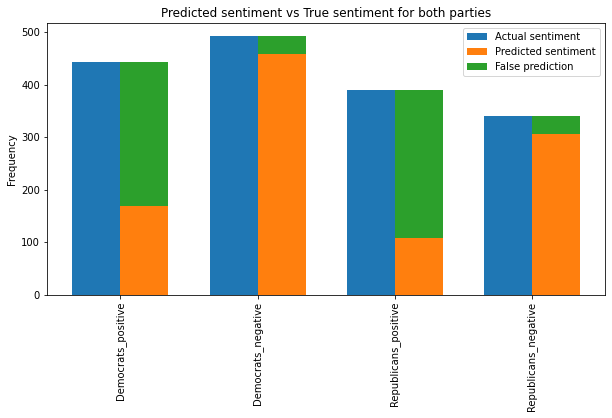

In [33]:
#plotting the Actual vs Predicted vs False prediction
labels = ['Democrats_positive', 'Democrats_negative', 'Republicans_positive', 'Republicans_negative']
actual = [dpa, dna, rpa, rna]
predicted = [dpp, dnp, rpp, rnp]
false = [dfn, dfp, rfn, rfp]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (10,5))
rects1 = ax.bar(x - width/2, actual, width, label='Actual sentiment')
rects2 = ax.bar(x + width/2, predicted, width, label='Predicted sentiment')
rects3 = ax.bar(x + width/2, false, width, bottom = predicted, label='False prediction')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_title('Predicted sentiment vs True sentiment for both parties')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

From the above graph we can see that eventhough the number of democrats in the dataset is higher than the republicans, the democrats showed more negative sentiments than positive sentiments. On the contrary, the republicans showed more positive sentiments than negative sentiments. 

Using tfidf features and SVM model, we got 62.81% prediction accuracy which is not great. We can see that the false positives for both the parties are high and the false negatives are low. This could be because we are using the tfidf features obtained through the generic dataset and testing the elections dataset with it. To improve the results, tfidf features specific to the election dataset should be vectorized and it should be used for evaluating the sentiments.

**Repeat the process for bag of words features of the generic tweets dataset. Target variable is the sentiment 'label' of the generic tweets data.**

In [34]:
#  training and testing data split for BoW features
X = bow
y = sentiment['label']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=1)

In [35]:
%%time
#logistic Regression
log_model = LogisticRegression()    
log_model = log_model.fit(X_train, y_train)
log_predictions = log_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, log_predictions)
print ("The logistic regression model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The logistic regression model got an accuracy of 93.28% on the testing set
Wall time: 5.22 s


In [36]:
%%time
#Decision Tree
dt_model = DecisionTreeClassifier()
dt_model = dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, dt_predictions)
print ("The Decision Tree model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The Decision Tree model got an accuracy of 91.82% on the testing set
Wall time: 2min 17s


In [37]:
%%time
#XG-Boost
xgb_model = xgb.XGBClassifier()
xgb_model = xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, xgb_predictions)
print ("The XGBoost ensemble got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The XGBoost ensemble got an accuracy of 90.01% on the testing set
Wall time: 13.1 s


In [38]:
%%time
#Naive Bayes
naive_model = MultinomialNB()    
naive_model = naive_model.fit(X_train, y_train)
naive_predictions = naive_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, naive_predictions)

print ("The Naive Bayes model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The Naive Bayes model got an accuracy of 90.77% on the testing set
Wall time: 141 ms


In [39]:
%%time
#Random Forest
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, rf_predictions)
print ("The Random Forest ensemble got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The Random Forest ensemble got an accuracy of 92.91% on the testing set
Wall time: 20min 42s


In [40]:
%%time
#kNN
kNN_model = KNeighborsClassifier()    
kNN_model = kNN_model.fit(X_train, y_train)
kNN_predictions = kNN_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, kNN_predictions)

print ("The k-nearest neighbours classifier got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The k-nearest neighbours classifier got an accuracy of 90.63% on the testing set
Wall time: 35min 36s


In [41]:
%%time
#SVM
svm_model = SVC()    
svm_model = svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, svm_predictions)

print ("The Support Vector Machine model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The Support Vector Machine model got an accuracy of 93.68% on the testing set
Wall time: 2h 42min 58s


We can see from the above results that Support Vector Machine model gave the best results with 93.68% accuracy for the Bag of Words features.

Let us now apply the best prediction model on the US_Elections_2020 dataset. Since Support Vector Machine model gave the best prediction results for BoW of the generic data set, we will apply SVM model with BoW features of the election dataset.

In [42]:
%%time
#predicting sentiment of election dataset using BoW features and SVM model
X_test = election_bow
y_test = election['sentiment']
svm_predictions = svm_model.predict(X_test)
ACC = metrics.accuracy_score(y_test, svm_predictions)

print ("The Support Vector Machine model got an accuracy of {}% on the elections data with BoW features".format(round(ACC*100,2)))  

The Support Vector Machine model got an accuracy of 63.79% on the elections data with BoW features
Wall time: 12.6 s


Let us now visualize sentiment prediction results and the true sentiment for each of the two parties/candidates.

In [43]:
election['svm_bow_sentiment'] = svm_predictions
dpa = dpp = dna = dnp = rpa = rpp = rna = rnp = dfn = dfp = rfn = rfp = 0
for i in tqdm(range(len(election))):
    if election['party'][i]== 'Democrat' and election['sentiment'][i]==1:
        dpa = dpa+1
        if election['svm_bow_sentiment'][i]==1:
            dpp = dpp+1
        elif election['svm_bow_sentiment'][i]==0:
            dfn = dfn+1
    elif election['party'][i]== 'Democrat' and election['sentiment'][i]==0:
        dna = dna+1
        if election['svm_bow_sentiment'][i]==0:
            dnp = dnp+1
        elif election['svm_bow_sentiment'][i]==1:
            dfp = dfp+1
    elif election['party'][i]== 'Republican' and election['sentiment'][i]==1:
        rpa = rpa+1
        if election['svm_bow_sentiment'][i]==1:
            rpp = rpp+1
        elif election['svm_bow_sentiment'][i]==0:
            rfn = rfn+1
    elif election['party'][i]== 'Republican' and election['sentiment'][i]==0:
        rna = rna+1
        if election['svm_bow_sentiment'][i]==0:
            rnp = rnp+1
        elif election['svm_bow_sentiment'][i]==1:
            rfp = rfp+1

100%|██████████| 2552/2552 [00:00<00:00, 10751.21it/s]


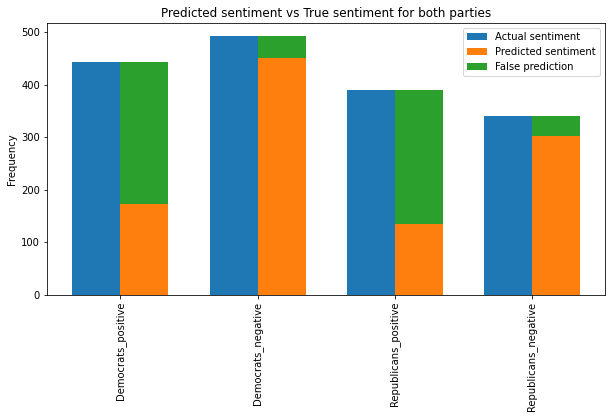

In [44]:
labels = ['Democrats_positive', 'Democrats_negative', 'Republicans_positive', 'Republicans_negative']
actual = [dpa, dna, rpa, rna]
predicted = [dpp, dnp, rpp, rnp]
false = [dfn, dfp, rfn, rfp]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (10,5))
rects1 = ax.bar(x - width/2, actual, width, label='Actual sentiment')
rects2 = ax.bar(x + width/2, predicted, width, label='Predicted sentiment')
rects3 = ax.bar(x + width/2, false, width, bottom = predicted, label='False prediction')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_title('Predicted sentiment vs True sentiment for both parties')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

From the above graph we can see that eventhough the number of democrats in the dataset is much higher than the republicans, the democrats showed more negative sentiments than positive sentiments. On the contrary, the republicans showed more positive sentiments than negative sentiments. Using Bag of Words features and SVM model, we got 62.81% prediction accuracy which is not great. We can see that the false positives for both the parties are high and the false negatives are low.

For both the feature sets (BoW and Tfidf), the accuracy of predictions are moderate. This is because we have used the model trained with generic tweets to predict the result of the elections data set. This means that the features specific to elections are not used to predict the elections sentiment. However, this can be improved by vectorizing the elections dataset and training its features using the ML algorithms, and then using the trained model to predict the results. This could give better prediction accuracy.

Also, our underlying assumptions for classifying the political parties might be flawed. Hence, a part of the sample could be labelled manually with the two political parties and then an ML model could be run to achieve better accuracy of the political party prediction. It can be used for further analysis to predict the sentiments of the political parties.

### Part 4b: Multi-class classification models and hyperparameter tuning to predict the reason for the negative tweets
We will now use the elections dataset and predict the reasons for the negative sentiments for each negative tweet. We will use logistic regression, decision tree, and kNN algorithms for the multi-class classification of the reasons for negative sentiments of the US_Elections dataset, using the tfidf vectorized features. The negative tweets will be split into 70%:30% as training and testing data sets. Hyperparameter tuning will involve tuning the appropriate hyperparameters for each ML model. Finally the three ML models with best hyperparameters will be used to predict the reason for the negative tweets.

In [45]:
#vectorizing the cleaned election tweets using tfidfvectorizer
text2 = election['text1'].tolist()

tfidf1 = TfidfVectorizer(analyzer = "word", stop_words=stop_words1, token_pattern = r'\b[^\d\W]+', max_features = 2000)
election_tf = tfidf1.fit_transform(text2)
election_tf_columns = tfidf1.get_feature_names()
election_tf

<2552x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 15278 stored elements in Compressed Sparse Row format>

In [46]:
#extracting only the negative reasons and the corresponding vectorized rows
tf1 = pd.DataFrame(election_tf.toarray())
neg_election_Y = election['negative_reason'].loc[election['sentiment']==0]
neg_election_tf = tf1.loc[election['sentiment']==0]

In [47]:
#splitting the data into train and testing set
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(neg_election_Y) #since the target variable is labelled as categories, we will encode it as numbers to apply the ML models
X = neg_election_tf
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=1)

#### We will now apply the three multi-class classification algorithms: logistic regression, decision tree, and kNN

In [48]:
%%time
#multi-class logistic regression on negative election dataset

log_model = LogisticRegression(multi_class='multinomial',solver='newton-cg')    
log_model = log_model.fit(X_train, y_train)
log_predictions = log_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, log_predictions)
print ("The logistic regression model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The logistic regression model got an accuracy of 38.68% on the testing set
Wall time: 346 ms


In [49]:
%%time
#multi-class Decision Tree on negative election dataset
dt_model = DecisionTreeClassifier()
dt_model = dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, dt_predictions)
print ("The Decision Tree model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The Decision Tree model got an accuracy of 28.95% on the testing set
Wall time: 747 ms


In [50]:
%%time
#multi-class kNN on negative election dataset
kNN_model = KNeighborsClassifier()    
kNN_model = kNN_model.fit(X_train, y_train)
kNN_predictions = kNN_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, kNN_predictions)

print ("The k-nearest neighbours classifier got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

The k-nearest neighbours classifier got an accuracy of 27.11% on the testing set
Wall time: 1.65 s


#### Let us perform hyperparameter tuning to select the best hyperparameters for the three ML models. Then predict the negative reason using all three models with best hyperparameters
Logistic regression : we will find the optimal 'C' value and 'solver' using grid search approach and 10-fold cross validation approach

Decision tree : we will find the optimal 'maximum tree depth', 'maximum features for best split', 'minimum samples in a leaf', and 'criterion to measure split quality' values using grid search and 10-fold cross validation approach

k-NN : we will find the optimal 'no. of neighbors for classification', 'minkowski power parameter, p', 'weight function used in prediction' values using grid search and 10-fold cross validation approach

In [51]:
%%time
#hyperparameter tuning Logistic Regression
gs = {"C": [0.001,0.01,0.05,0.1,0.5,1,5,10, 100], "solver": ['newton-cg','lbfgs','sag']}
lr = LogisticRegression(multi_class='multinomial')
lr_param = GridSearchCV(lr,gs,cv=10)
lr_param.fit(X_train, y_train)
best_lr_param = lr_param.best_params_
#prediction using best Logistic Regression hyperparameters
lr_model = LogisticRegression(multi_class='multinomial', C = best_lr_param['C'], solver = best_lr_param['solver'])
lr_model = lr_model.fit(X_train,y_train)
lr_predictions = lr_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, lr_predictions)

print ("The Logistic regression model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))
print ("The optimal hyperparameters for the logistic regression model is ", best_lr_param)

The Logistic regression model got an accuracy of 38.68% on the testing set
The optimal hyperparameters for the logistic regression model is  {'C': 1, 'solver': 'newton-cg'}
Wall time: 4min 33s


In [52]:
%%time
#hyperparameter tuning Decision Tree
gs = {"max_depth": np.linspace(1,32,32), "max_features": np.linspace(1,2000,20), "min_samples_leaf": [0.02, 0.04, 0.06, 0.08, 0.1,0.2, 0.3, 0.4, 0.5],"criterion": ["gini", "entropy"]}
dt = DecisionTreeClassifier()
dt_param = GridSearchCV(dt,gs,cv=10)
dt_param.fit(X_train, y_train)
best_dt_param = dt_param.best_params_
#prediction using best Decision Tree hyperparameters
dt_model = DecisionTreeClassifier(max_features = best_dt_param['max_features'], max_depth = best_dt_param['max_depth'], min_samples_leaf= best_dt_param['min_samples_leaf'] , criterion = best_dt_param['criterion'])
dt_model = dt_model.fit(X_train,y_train)
dt_predictions = dt_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, dt_predictions)

print ("The Decision Tree classifier got an accuracy of {}% on the testing set".format(round(ACC*100,2)))
print ("The optimal hyperparameters for the decision tree model is ", best_dt_param)

The Decision Tree classifier got an accuracy of 31.58% on the testing set
The optimal hyperparameters for the decision tree model is  {'criterion': 'gini', 'max_depth': 8.0, 'max_features': 1.0, 'min_samples_leaf': 0.02}
Wall time: 1h 13min 12s


In [53]:
%%time
#hyperparameter tuning kNN
#https://ca-lti.bbcollab.com/collab/ui/session/playback
gs = {'n_neighbors': np.arange(1,20), 'p': [1,2], 'weights':['uniform','distance']}
kNN = KNeighborsClassifier()
kNN_param = GridSearchCV(kNN,gs,cv=10)
kNN_param.fit(X_train, y_train)
best_kNN_param = kNN_param.best_params_
#prediction using best kNN hyperparameters
kNN_model = KNeighborsClassifier(n_neighbors = best_kNN_param['n_neighbors'], p= best_kNN_param['p'] , weights = best_kNN_param['weights'])
kNN_model = kNN_model.fit(X_train,y_train)
kNN_predictions = kNN_model.predict(X_test)

ACC = metrics.accuracy_score(y_test, kNN_predictions)

print ("The k-nearest neighbours classifier got an accuracy of {}% on the testing set".format(round(ACC*100,2)))
print ("The optimal hyperparameters for the kNN model is ", best_kNN_param)

The k-nearest neighbours classifier got an accuracy of 37.63% on the testing set
The optimal hyperparameters for the kNN model is  {'n_neighbors': 16, 'p': 1, 'weights': 'distance'}
Wall time: 7min 14s


All the above three models perform poorly in predicting the reasons for negative sentiment. This may be because the tfidf features used to predict the negative reason are not sufficient to do accurate prediction. The tfidf features do not capture the real intent,quality, relevance and context of words used in the sentence. 

The other reason for the lower accuracy could be because the original classification of the reasons are unreliable because the negative reasons given for each negative tweet is inconsistent and at many instances not a relevant reason at all. From the below example we can see that the tweet is surely related to COVID-19, but it was originally classified as corruption.

In [54]:
print('Original tweet :', election['text'][27], 'Original sentiment :', election['negative_reason'][27])

Original tweet : b'@brikeilarcnn @socalmom the truth is that the #covid19 deaths, the children separated from parents, dead &  Original sentiment : corruption


However, the accuracy could be improved by manually coding the correct reasons on the training set and using it to predict the test set.

In the above example, first the tweets are vectorized and then the negative tweets and the reasons are separated from it. This means that the vector features will contain both positive and negative features. If the negative tweets are first separated and then vectorized, we will obtain better features which are negative. This can improve the accuracy of the prediction.